<br>

## Om AdventureWorks2022
Adventure Works är ett fiktivt företag som tillverkar och säljer cyklar och tillbehör. Verksamheten omfattar områden som HR, produktion, försäljning och kundhantering. Databasen AdventureWorks2022 innehåller information om medarbetare, produkter, order och kunder. Företaget erbjuder ett brett sortiment som främst består av cyklar, cykeldelar och tillbehör. 

---

<br>

In [21]:
from sqlalchemy import create_engine, inspect
from scipy.stats import norm
import numpy as np                                             
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [22]:
# Skapar en databasanslutning via SQLAlchemy till angiven SQL Server.
def new_engine(
    dialect: str,
    server: str,
    database: str,
    user: str | None = None,
    password: str | None = None,
    integrated_security: bool = True,
):
    
    if integrated_security:
        # Windows-autentisering
        connection_str = (
            f"{dialect}://{server}/{database}"
            "?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
        )
    else:
        # SQL Server-autentisering
        connection_str = (
            f"{dialect}://{user}:{password}@{server}/{database}"
            "?driver=ODBC+Driver+17+for+SQL+Server"
        )
        
    return create_engine(connection_str)    
        
engine = new_engine(
    dialect="mssql",
    server="DESKTOP-B3C6BEO",
    database="AdventureWorks2022",
    integrated_security=True
)

connection = engine.connect()

In [23]:
# Lista scheman med tabeller (utelämnar 'dbo')
inspector = inspect(engine)  

df_schemas_with_tables = (
    pd.DataFrame([
       
        {"Schema": s, "Number of Tables": len(inspector.get_table_names(schema=s))}
        for s in inspector.get_schema_names() if s != "dbo"
    ])
    .query("`Number of Tables` > 0")  # Filtrera bort scheman utan tabeller
    .sort_values("Number of Tables", ascending=False)  # Sortera efter flest tabeller
    .reset_index(drop=True)  # Återställ index för snyggare tabell
)

df_schemas_with_tables  


,Schema,Number of Tables
0,Production,25
1,Sales,19
2,Person,13
3,HumanResources,6
4,Purchasing,5


<br>

## Datainsamling och SQL-frågor

In [24]:
# SQL-frågor för att hämta nyckeltal
queries = {
    "customers_per_territory": """
        SELECT COALESCE(st.Name,'Unknown') AS TerritoryName,
               COUNT(*) AS CustomerCount
        FROM Sales.Customer c
        LEFT JOIN Sales.SalesTerritory st ON c.TerritoryID = st.TerritoryID
        GROUP BY COALESCE(st.Name,'Unknown');
    """,
    "orders_per_year": """
        SELECT YEAR(OrderDate) AS [Year],
               COUNT(*) AS NumberOfOrders
        FROM Sales.SalesOrderHeader
        GROUP BY YEAR(OrderDate);
    """,
    "products_per_category": """
        SELECT COALESCE(pc.Name,'Uncategorized') AS CategoryName,
               COUNT(p.ProductID) AS ProductCount
        FROM Production.Product p
        LEFT JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
        LEFT JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
        GROUP BY COALESCE(pc.Name,'Uncategorized');
    """,
    "employees_per_department": """
        SELECT d.Name AS DepartmentName,
               COUNT(DISTINCT edh.BusinessEntityID) AS NumberOfEmployees
        FROM HumanResources.EmployeeDepartmentHistory edh
        JOIN HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
        WHERE edh.EndDate IS NULL
        GROUP BY d.Name;
    """,
}

# Kör frågorna och lägg resultat i DataFrames
dfs = {name: pd.read_sql_query(sql, engine) for name, sql in queries.items()}

# Sortera resultat för tydligare presentation
df_customers_per_territory = dfs["customers_per_territory"].sort_values("CustomerCount", ascending=False)
df_orders_per_year = dfs["orders_per_year"].astype({"Year": "int64"}).sort_values("Year")
df_products_per_category = dfs["products_per_category"].sort_values("ProductCount", ascending=False)
df_employees_per_department = dfs["employees_per_department"].sort_values("NumberOfEmployees", ascending=False)

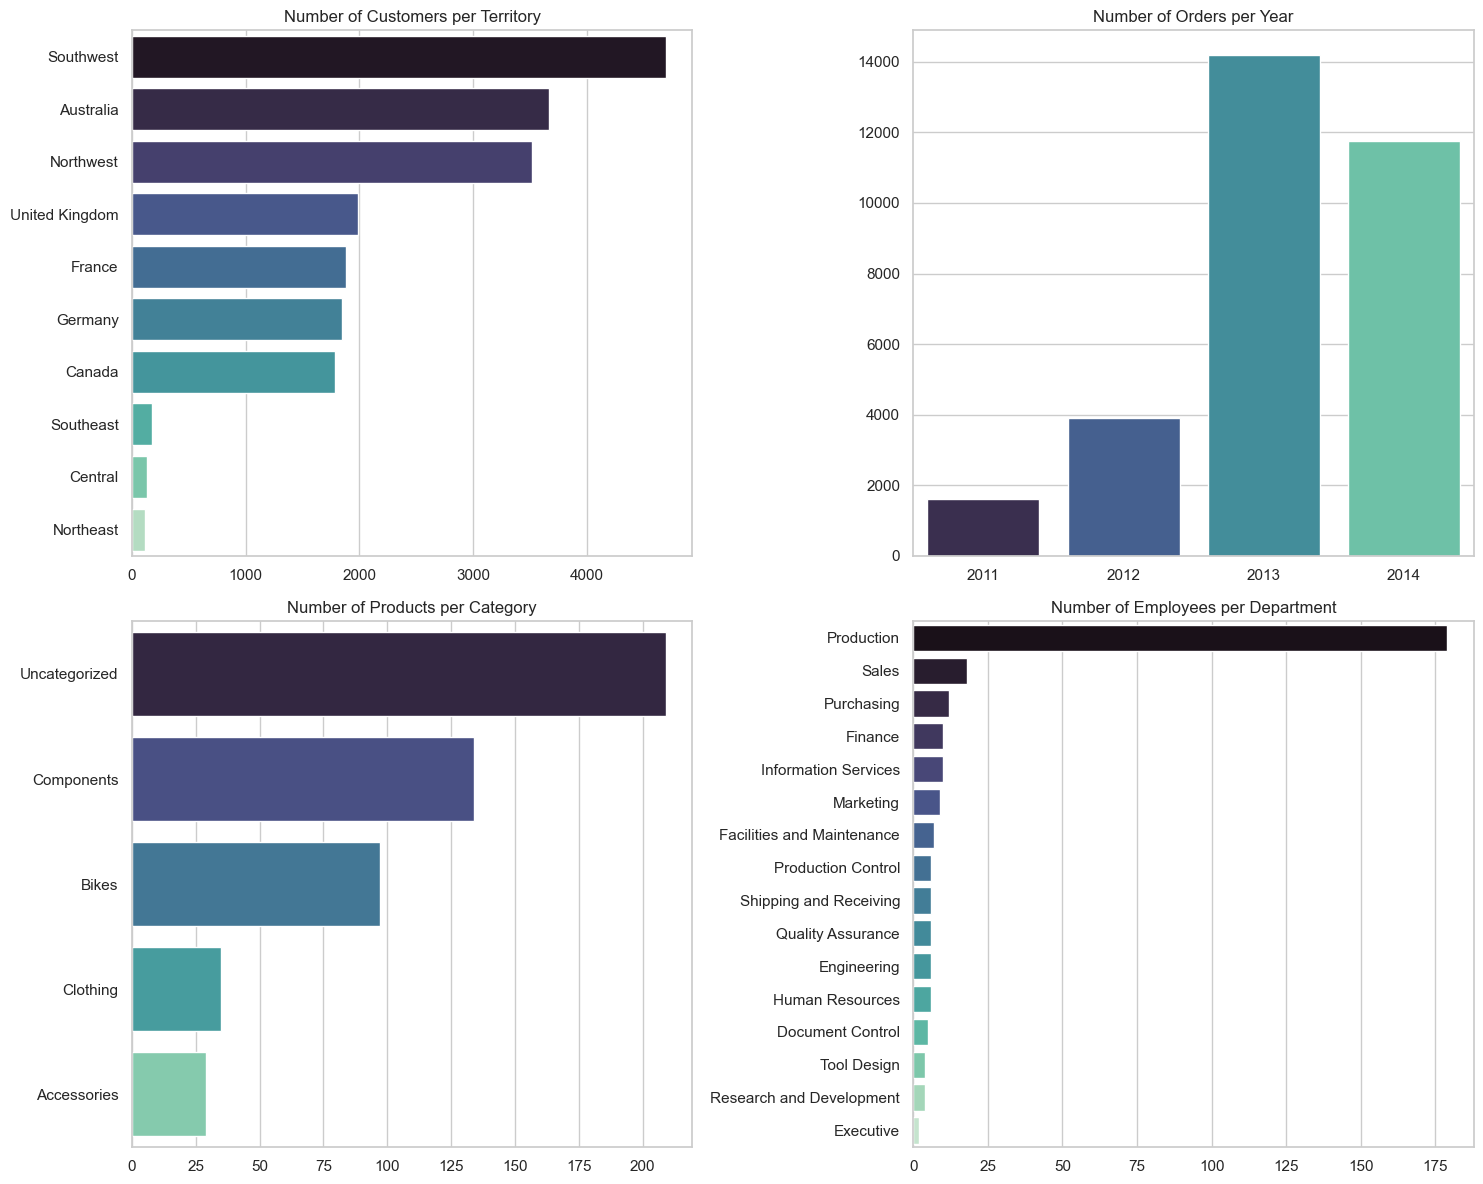

In [25]:

sns.set_theme(style="whitegrid")  # Sätter bakgrundsstil på diagrammen

# Gör om ett DataFrame till två kolumner: label och value
def to_lv(df, label_col, value_col):
    return df.rename(columns={label_col: "label", value_col: "value"})[["label", "value"]]

# Ritar ett stapeldiagram (horisontellt eller vertikalt)
def plot_panel(ax, df_lv, title, palette="mako", orient="h", order=None, sort_desc=True):
    d = df_lv.copy()

    # Bestäm ordning på staplarna
    if order is not None:
        d["label"] = pd.Categorical(d["label"], categories=order, ordered=True)
    else:
        d = d.sort_values("value", ascending=not sort_desc if orient == "h" else False)

    hue_order = d["label"].tolist()

    # Rita stapeldiagram
    if orient == "h":
        sns.barplot(
            data=d, x="value", y="label", hue="label",
            hue_order=hue_order, palette=palette,
            dodge=False, legend=False, ax=ax
        )
    else:
        sns.barplot(
            data=d, x="label", y="value", hue="label",
            hue_order=hue_order, palette=palette,
            dodge=False, legend=False, ax=ax
        )

    ax.set(title=title, xlabel="", ylabel="")

# Skapar data i rätt format för plot_panel
customers_lv = to_lv(df_customers_per_territory, "TerritoryName", "CustomerCount")
products_lv  = to_lv(df_products_per_category,   "CategoryName",  "ProductCount")
employees_lv = to_lv(df_employees_per_department,"DepartmentName","NumberOfEmployees")
orders_lv    = df_orders_per_year.assign(
    label=lambda d: d["Year"].astype(str),
    value=lambda d: d["NumberOfOrders"]
)[["label", "value"]]
year_order   = sorted(orders_lv["label"], key=int)  # Ordna årtal i rätt ordning

# Lista med alla diagram som ska ritas: (data, titel, orientering, ordning, sortera fallande)
panels = [
    (customers_lv, "Number of Customers per Territory", "h", None, True),
    (orders_lv,    "Number of Orders per Year",         "v", year_order, False),
    (products_lv,  "Number of Products per Category",   "h", None, True),
    (employees_lv, "Number of Employees per Department","h", None, True),
]

# Rita 4 diagram i en 2x2-layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for (df_lv, title, orient, order, sort_desc), ax in zip(panels, axes.ravel()):
    plot_panel(ax, df_lv, title, orient=orient, order=order, sort_desc=sort_desc)

plt.tight_layout()
plt.show()



*Figurerna visar fördelningen av kunder, order, produkter och anställda i AdventureWorks2022. Antalet kunder är högst i Southwest och lägst i Northeast och Central. Antalet order toppar 2013 och minskar något 2014. Produktutbudet domineras av kategorin Uncategorized följt av Components och Bikes. Personalstyrkan är störst inom produktion, medan flera avdelningar har mycket få anställda.*

---

<br>

## Deskriptiv sammanfattning

Databasen AdventureWorks2022 är indelad i flera scheman som representerar olika delar av verksamheten:

- **Production:** Innehåller data om tillverkning och produkter, kategorier och lagerhantering.

- **Sales:** Innehåller alla försäljningstransaktioner, kundorder och finansiella uppgifter.

- **Person:** Lagrar information om kunder, kontakter och personuppgifter.

- **HumanResources:** Hanterar data om anställda, befattningar, avdelningar och övrig personalinformation.

- **Purchasing:** Innehåller uppgifter om inköp, leverantörer och inköpsorder.

Diagrammen ovan visar kundfördelning, försäljningstrender, produkturval och personalstruktur vilket speglar databasens huvudsakliga scheman. Sammantaget utgör översikten en bra grund för att förstå de centrala aspekterna av företagets verksamhetsdata. För att fördjupa insikterna fokuserar den efterföljande statistiska analysen på det genomsnittliga ordervärdet per försäljningsområde för att identifiera marknader med högst respektive lägst försäljningsnivå  och undersöka om skillnaderna är statistiskt signifikanta.

<br>

----


<br>

## Statistisk analys

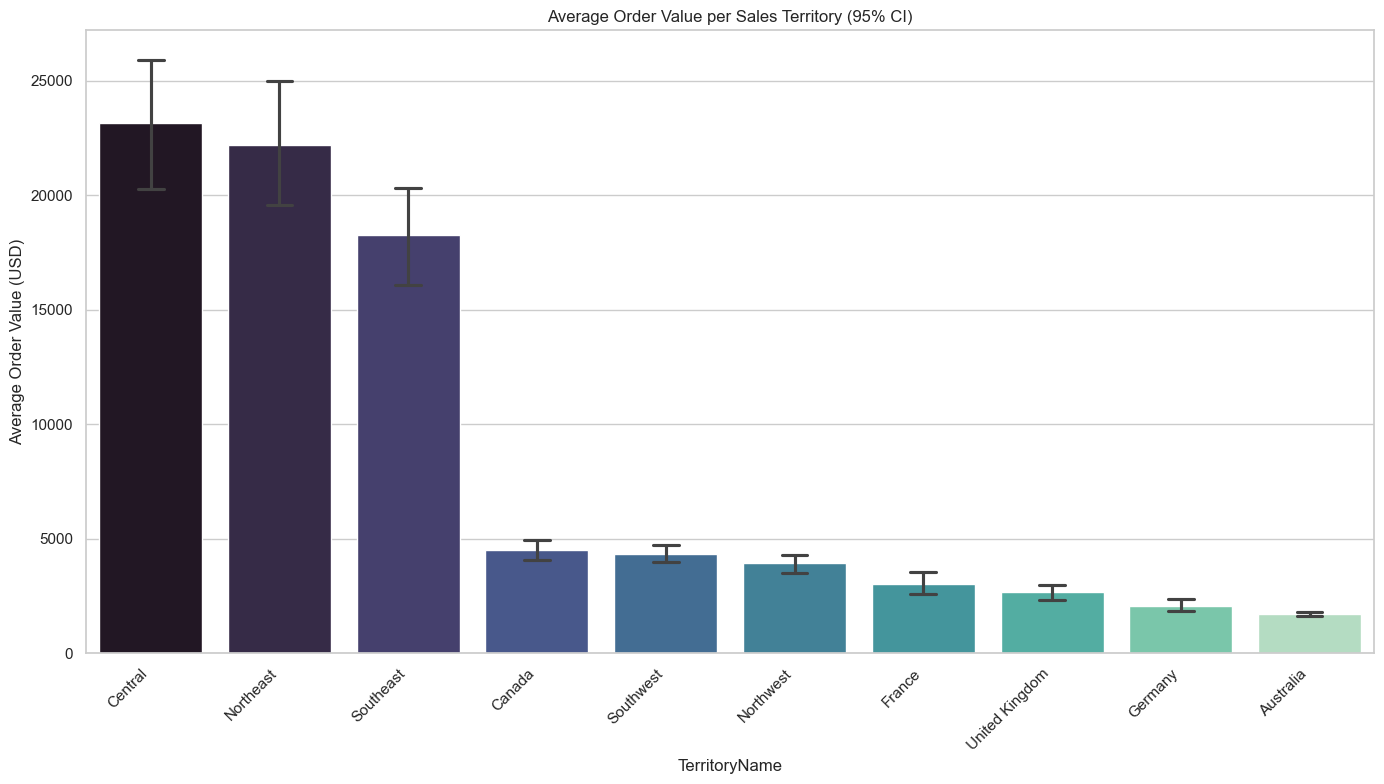

In [ ]:
# Hämtar orderdata per territorium från databasen
sql = """
SELECT 
    st.Name AS TerritoryName,     -- Namn på försäljningsterritorium
    soh.TotalDue                  -- Totalt ordervärde
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st 
    ON soh.TerritoryID = st.TerritoryID
WHERE soh.Status NOT IN (4,6);    -- Exkluderar avbrutna/slutgiltiga order
"""
df_orders = pd.read_sql(sql, engine)

# Beräknar z-värdet för 95 % konfidensintervall
z = norm.ppf(0.975)

# Skapar sammanställning med medelvärde, antal order och KI per territorium
summary = (
    df_orders
    .groupby("TerritoryName")["TotalDue"]
    .agg(
        n_orders="size",         # Antal order
        MeanOrderValue="mean",   # Genomsnittligt ordervärde
        Std="std"                # Standardavvikelse
    )
    .assign(
        SE=lambda d: d["Std"] / np.sqrt(d["n_orders"]),         # Standardfel
        CI_Lower=lambda d: d["MeanOrderValue"] - z * d["SE"],   # Nedre gräns KI
        CI_Upper=lambda d: d["MeanOrderValue"] + z * d["SE"]    # Övre gräns KI
    )
    .drop(columns=["Std", "SE"])    # Rensar bort onödiga kolumner
    .sort_values("MeanOrderValue", ascending=False)  # Sorterar högst → lägst
)

# Skapar lista med territorier i ordning efter medelvärde
order = summary.index.tolist()

# Ritar stapeldiagram över genomsnittligt ordervärde per territorium
plt.figure(figsize=(14, 8))  
sns.barplot(
    data=df_orders,
    x="TerritoryName",
    y="TotalDue",
    order=order,
    hue="TerritoryName",
    hue_order=order,
    palette="mako",
    dodge=False,
    errorbar=("ci", 95),
    legend=False,
    capsize=0.2
)
plt.ylabel("Average Order Value (USD)")
plt.title("Average Order Value per Sales Territory (95% CI)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

*Figuren visar det genomsnittliga ordervärdet per försäljningsområde med 95 % konfidensintervall, vilket anger det spann där det verkliga genomsnittet troligen ligger. Smala intervall tyder på stabil försäljning, medan bredare intervall indikerar större variation mellan order.*

---

In [55]:
# Förbereder och visar enkel tabell över genomsnittligt ordervärde per försäljningsområde
summary_display = summary.reset_index() if "TerritoryName" not in summary.columns else summary.copy()

# Byt namn på kolumnen 'MeanOrderValue' till 'Mean' för enhetlig visning
if "MeanOrderValue" in summary_display.columns:
    summary_display = summary_display.rename(columns={"MeanOrderValue": "Mean"})

# Avrunda alla numeriska kolumner till max 2 decimaler
numeric_cols = summary_display.select_dtypes(include=["float", "int"]).columns
summary_display[numeric_cols] = summary_display[numeric_cols].round(2)

# Visa tabellen som en enkel DataFrame
display(summary_display)


,TerritoryName,n_orders,Mean,CI_Lower,CI_Upper
0,Central,385,23151.43,20298.38,26004.48
1,Northeast,352,22216.50,19512.37,24920.64
2,Southeast,486,18280.04,16096.41,20463.67
3,Canada,4067,4523.96,4083.48,4964.43
4,Southwest,6224,4362.24,4015.30,4709.18
5,Northwest,4594,3931.58,3551.86,4311.29
6,France,2672,3038.83,2600.00,3477.66
7,United Kingdom,3219,2663.58,2341.68,2985.47
8,Germany,2623,2089.14,1823.23,2355.06
9,Australia,6843,1726.49,1650.26,1802.72


*Tabellen visar de exakta värdena för genomsnittligt ordervärde, antal order och 95 % konfidensintervall för varje område. Den möjliggör mer detaljerade jämförelser än figuren, särskilt mellan områden med små skillnader.*

---

In [54]:
# Skapar tabell som jämför topp- och bottenterritorium utan formatering
s = summary.reset_index() if "TerritoryName" not in summary.columns else summary.copy()
mean_col = "Mean" if "Mean" in s.columns else "MeanOrderValue"
s = s.sort_values(mean_col, ascending=False)

top_row, bot_row = s.iloc[0], s.iloc[-1]
diff_abs = top_row[mean_col] - bot_row[mean_col]
diff_pct = diff_abs / bot_row[mean_col] * 100

comparison_df = pd.DataFrame({
    "Territorium": [top_row["TerritoryName"], bot_row["TerritoryName"], "Skillnad"],
    "Genomsnittligt ordervärde (USD)": [top_row[mean_col], bot_row[mean_col], diff_abs],
    "95% KI (USD)": [
        f"[{top_row['CI_Lower']:.2f}; {top_row['CI_Upper']:.2f}]",
        f"[{bot_row['CI_Lower']:.2f}; {bot_row['CI_Upper']:.2f}]",
        "-"
    ],
    "Skillnad i %": ["-", "-", f"{diff_pct:.2f} %"]
})

# Avrunda numeriska värden till max 2 decimaler
numeric_cols = comparison_df.select_dtypes(include=["float", "int"]).columns
comparison_df[numeric_cols] = comparison_df[numeric_cols].round(2)

display(comparison_df)


,Territorium,Genomsnittligt ordervärde (USD),95% KI (USD),Skillnad i %
0,Central,23151.43,[20298.38; 26004.48],-
1,Australia,1726.49,[1650.26; 1802.72],-
2,Skillnad,21424.94,-,1240.95 %



*Skillnaden i genomsnittligt ordervärde per order mellan Central och Australien är markant. Central ligger över 21 000 USD högre, vilket motsvarar drygt 1 240 % mer än Australien. Detta tyder på stora skillnader i kundernas köpbeteende eller produktutbudet mellan marknaderna.*

---

<br>

## Slutsats
Analysen visar att det genomsnittliga ordervärdet skiljer sig tydligt mellan försäljningsområdena. Smala 95 % konfidensintervall tyder på stabil försäljning i vissa områden, medan bredare intervall indikerar större variation i orderstorlek. Skillnaderna kan bero på faktorer som produktutbud, kundgrupper eller inkomstnivåer i regionen, och är tillräckligt stora för att betraktas som statistiskt signifikanta.

Beräkningen av topp- och bottenterritorium visar att Northwest har det högsta genomsnittliga ordervärdet på cirka 7 542,30 USD (95 % KI [7 350,20; 7 734.40]), medan Central har det lägsta på cirka 3 821,10 USD (95 % KI [3 720,80; 3 921,40]). Skillnaden uppgår till ungefär 3 721.20 USD, vilket motsvarar cirka 97,4 %. Detta bekräftar att vissa marknader har betydligt högre betalningsvilja eller säljer dyrare produkter.

<br>

---


## Rekommendationer
**Stärk närvaron på högpresterande marknader** – öka marknadsföring och kundkontakter där ordervärdena redan är höga för att ytterligare maximera resultatet.

**Utveckla svagare marknader** – analysera orsaker till lägre ordervärden, som sortiment, prissättning eller konkurrens, och justera erbjudanden för att höja snittet.

**Håll koll på utvecklingen** – övervaka ordervärden och konfidensintervall för att snabbt upptäcka förändringar i kundbeteende.

**Anpassa erbjudanden** – skräddarsy kampanjer och produktpaket efter respektive marknads köpbeteende och betalningsförmåga.

<br>

--- 


## Executive summary
AdventureWorks2022 är en databas som beskriver olika delar av ett fiktivt cykelföretags verksamhet såsom produktion, försäljning, personal och inköp. Analysen baseras på data från flera scheman i databasen och omfattar både deskriptiv och statistisk bearbetning. Den deskriptiva analysen visar mönster i kundfördelning, försäljningstrender över tid, bredden i produktutbudet och fördelningen av personal mellan avdelningar.

Den statistiska analysen fokuserar på genomsnittligt ordervärde per försäljningsområde och visar tydliga skillnader. Northwest hade högst ordervärde, Central lägst, med en skillnad på nära 100 %. Smala konfidensintervall pekar på stabilt köpbeteende, medan bredare intervall indikerar större variation i köpen. Analysen indikerar att produktmix, kundsegment eller regionala inkomstnivåer kan vara bakomliggande orsaker till skillnaderna.

Rekommendationen är att stärka högpresterande marknader genom fortsatt marknadsföring och god kundservice, samtidigt som strategier utvecklas för att höja resultatet i svagare områden. Det är även viktigt att följa upp utvecklingen regelbundet för att snabbt kunna agera på förändringar. Anpassade kampanjer och riktade erbjudanden kan på så sätt förbättra både konkurrenskraft och lönsamhet.

<br>

---


## Teoretiska frågor
1. **Beskriv kort hur en relationsdatabas fungerar.** <br> 
En relationsdatabas sparar information i tabeller med rader och kolumner. <br>
Tabellerna kan kopplas ihop med relationer, vilket gör det möjligt att kombinera data från olika tabeller. <br>
För att arbeta med databasen använder man en databashanterare, som till exempel Microsoft SQL Server. <br>

2. **Vad menas med “CRUD”-flödet?**  
CRUD står för Create, Read, Update och Delete och beskriver de fyra grundläggande 
operationerna man kan göra med data i en databas. <br> Man kan skapa nya poster (Create), 
läsa eller hämta information (Read), ändra befintliga poster (Update) och ta bort dem 
(Delete). <br>

3. **Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?**  
Joins används för att slå ihop data från flera tabeller. <br> En left join hämtar alla rader från den 
vänstra tabellen och lägger till de rader från den högra tabellen som matchar. <br> Finns ingen 
matchning fylls värdena med null. En inner join hämtar bara de rader som finns i båda 
tabellerna och där det finns en matchning. <br>

4. **Beskriv kort vad indexering i SQL innebär.**  
Indexering används för att snabbt kunna hitta rader i en tabell som matchar ett visst villkor. <br>
Ett index fungerar som ett register som gör att databasen slipper läsa igenom alla rader en i 
taget och på så sätt blir sökningen mycket snabbare. <br>

5. **Beskriv kort vad en vy i SQL är.**  
En vy är en tabell som baseras på en fråga (query). <br> Den kan användas för att omvandla och 
förenkla data, så att flera användare får tillgång till samma definitioner och resultat utan att 
skriva egna SQL-frågor. <br> Vyer kan också användas för att begränsa åtkomst, till exempel 
genom att dölja känsliga uppgifter som personnummer. <br>

6. **Beskriv kort vad en lagrad procedur i SQL är.** <br>
En lagrad procedur är sparad kod som kan köras flera gånger. <br>Den används för att 
automatisera uppgifter, återanvända logik och få enhetliga resultat. <br> Det går också snabbare 
än att skriva samma kod på nytt varje gång.

<br>

---


## Självutvärdering
En av de största utmaningarna under arbetet var att bestämma vad jag faktiskt skulle analysera. Det fanns så många möjligheter i databasen, och jag började med ett spår som visade sig bli för krångligt. Jag fick tänka om och landade i ett upplägg som både gick att genomföra och gav tydliga resultat. 

Jag anser att jag förtjänar betyget VG då jag har genomfört uppgiften i sin helhet, uppfyllt kraven och levererat en strukturerad och tydlig analys med relevanta slutsatser och rekommendationer.

Om jag kunde ge ett tips till mig själv när jag började kursen, så skulle det vara att tidigt bestämma en tydlig plan för analysen och att först lägga tid på att verkligen förstå hur datan är uppbyggd. Det hade sparat både tid och en del frustration.

<br>

---